# Starbucks Capstone Project

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).


## Objective of the project

- Using the user's demographics, offer data and the customer's transaction data to build a model that predicts if an user is going to complete the offer or not.

## Approach

- In this project we will use the user demographics data, the offer data and transaction data if they have viewed and completed an offer. Only the BOGO and DISCOUNT offer will be considered in this analysis. Then necessary data cleaning and transformation needs to be done to make the data ready for fitting into a supervised binary classification ML model. For evaluating the model performance ACCURACY will be used as a metric.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime

# for model building
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# for model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_colwidth', None)

## 2. Read the necessary data & Explore the tables

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [2]:
portfolio = pd.read_json('../data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../data/profile.json', orient='records', lines=True)
transcript = pd.read_json('../data/transcript.json', orient='records', lines=True)

#### Portfolio

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


#### Profile

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


#### Transcript

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### Observations of tables

**Portfolio**
- The channels column can be split into different channels columns
- id column can be renamed to offer id

**Profile**
- id column can be renamed into person
- There are certain persons that didn't reveal their age, gender and income
- New features can be made from became_member_on column by calculating the membership duration.

**Transcript**
- This dataframe can be broken down into 4 different dataframes : transactions, offer received, offer viewed, offer completed
- The value column needs to expanded for different scenarios


## 3. Data Cleaning & Transformation

#### Portfolio

In [6]:
# in this project we are considering on BOGO and DISCOUNT offer types
portfolio = portfolio.query("offer_type == 'bogo' | offer_type == 'discount'")

# create dummies for channels column
portfolio = portfolio.join(portfolio["channels"].str.join(sep=";").str.get_dummies(sep=";"))

# rename id column
portfolio.rename(columns = {"id": "offer id"}, inplace=True)

# drop channels column
portfolio.drop(columns = "channels", inplace=True)

In [7]:
portfolio.head()

,reward,difficulty,duration,offer_type,offer id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1


#### Profile

In [8]:
# check the number of user that didn't wish to reveal their demographic information

profile.gender.isnull().mean()

0.12794117647058822

- As the missing values cannot be replaced with imputation because it will lead to including wrong information in the dataset and the number of null values are lesser (12 % of total population) we can drop the users with null values.

In [9]:
# drop the nulls
profile.dropna(subset="gender", inplace=True)

# rename the id column
profile.rename(columns = {"id": "person"}, inplace=True)

# create a new column called membership duration. It is the difference between 2019-01-01 and the 
# date of became member on 
profile["became_member_on"] = pd.to_datetime(profile.became_member_on, format='%Y%m%d')
profile["membership_period"] = (datetime.strptime('2019-01-01', '%Y-%m-%d') - profile["became_member_on"]).dt.days

# drop became_member_on column
profile.drop(columns = 'became_member_on', inplace = True)

In [10]:
profile.head()

,gender,age,person,income,membership_period
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,535
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,602
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,250
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,326
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,416


#### Transcript

In [11]:
# create 4 different datasets from transcript dataset
transaction_df = transcript.query(f"event == 'transaction'")
offer_received_df = transcript.query(f"event == 'offer received'")
offer_viewed_df = transcript.query(f"event == 'offer viewed'")
offer_completed_df = transcript.query(f"event == 'offer completed'")

transcript_df_list = [transaction_df, offer_received_df, offer_viewed_df, offer_completed_df]

# reset index
for item in transcript_df_list:
    item.reset_index(drop=True, inplace=True)
    
# expand the value column
transaction_df = transaction_df.join(pd.json_normalize(transaction_df.value))
offer_received_df = offer_received_df.join(pd.json_normalize(offer_received_df.value))
offer_viewed_df = offer_viewed_df.join(pd.json_normalize(offer_viewed_df.value))
offer_completed_df = offer_completed_df.join(pd.json_normalize(offer_completed_df.value))


# drop the value column for the 4 dataframes
transaction_df.drop(columns = ["value", "event"], inplace=True)
offer_received_df.drop(columns = ["value", "event"], inplace=True)
offer_viewed_df.drop(columns = ["value", "event"], inplace=True)
offer_completed_df.drop(columns = ["value", "event", "reward"], inplace=True)

# rename the offer_id column of offer_completed_df to offer id 
offer_completed_df.rename(columns={"offer_id": "offer id"}, inplace=True)

# join the protfolio details to the 4 dataframes
offer_received_df = pd.merge(offer_received_df, portfolio, how='inner',
                            on='offer id')

offer_viewed_df = pd.merge(offer_viewed_df, portfolio, how='inner',
                          on='offer id')

offer_completed_df = pd.merge(offer_completed_df, portfolio, how='inner',
                             on='offer id')

# create a new feature called time_end that describes till when the offer is available
offer_received_df["time_offer_end"] = offer_received_df["time"] + offer_received_df["duration"]*24

# make offer recieved index as unique ids for offer received
offer_received_df.reset_index(inplace=True)

# rename time related columns
transaction_df.rename(columns={"time": "time_txn"}, inplace=True)
offer_received_df.rename(columns={"time": "time_offer_start",
                                  "index": "offer_rec_id"}, inplace=True)
offer_viewed_df.rename(columns={"time": "time_viewed"}, inplace=True)
offer_completed_df.rename(columns={"time": "time_completed"}, inplace=True)

In [12]:
offer_received_df.head()

,offer_rec_id,person,time_offer_start,offer id,reward,difficulty,duration,offer_type,email,mobile,social,web,time_offer_end
0,0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1,168
1,1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1,168
2,2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1,168
3,3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1,168
4,4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1,168


**Defination of good response**

- The customer receives an offer and views and completes the offer within the expiry window.


**Approach for identifying users that viewed and then completed an offer**

- There is no unique id for the received offer. To tackle this issue the index of the offer received dataframe is converted to a column as unique offer id.

- In the offers viewed and offers completed dataset the unique offer id column is not present, so time is used a parameter to identify if a user has viewed and completed an offer.

- For offer viewed : time_viewed < time_offer_end and time_viewed >= time_offer_start.

- For offer completed : time_completed < time_offer_end and time_completed >= time_viewed.


In [13]:
# create a dataframe that contains the offers that were received and viewed within the expiry window

offer_rec_view = pd.merge(offer_received_df[["offer_rec_id", "person", "offer id", "time_offer_start", "time_offer_end"]],
                          offer_viewed_df, how='inner',
                          on=["person", "offer id"])

offer_rec_view = offer_rec_view.query("(time_viewed < time_offer_end) and (time_viewed >= time_offer_start)")
offer_rec_View = offer_rec_view.loc[offer_rec_view.groupby(by=["person", "offer id", "time_offer_start"]).time_viewed.idxmin()]

# create a dataframe that contains the offers that were viewed and completed within the expiry window
offer_view_comp = pd.merge(offer_rec_view[["offer_rec_id", "person", "offer id", "time_viewed", "time_offer_end"]],
                          offer_completed_df, how='inner',
                          on=["person", "offer id"])

offer_view_comp = offer_view_comp.query("(time_completed < time_offer_end) and (time_completed >= time_viewed)")



In [14]:
# create temporary dataframe that contains the positive responses from users (offer completed)

offer_positive = offer_received_df[offer_received_df.offer_rec_id.isin(offer_view_comp.offer_rec_id.tolist())]
offer_positive["offer_completed"] = 1

# create temporary dataframe that contains the negative responses from users (offer not completed)
offer_negative = offer_received_df[~ offer_received_df.offer_rec_id.isin(offer_view_comp.offer_rec_id.tolist())]
offer_negative["offer_completed"] = 0

# concatenate the two dataframes
offer_final_df = pd.concat([offer_positive, offer_negative], ignore_index=True)

# join the profile dataframe to the offer final dataframe
offer_final_df = pd.merge(offer_final_df, profile,
                         how='inner', on='person')

# drop the person, offer id and offer_rec_id column
offer_final_df.drop(columns=["person", "offer id", "offer_rec_id"], inplace=True)

<ipython-input-14-1cea0acbdd51>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_positive["offer_completed"] = 1
<ipython-input-14-1cea0acbdd51>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_negative["offer_completed"] = 0


## 4. Univariate and Multivariate analysis

#### Profile

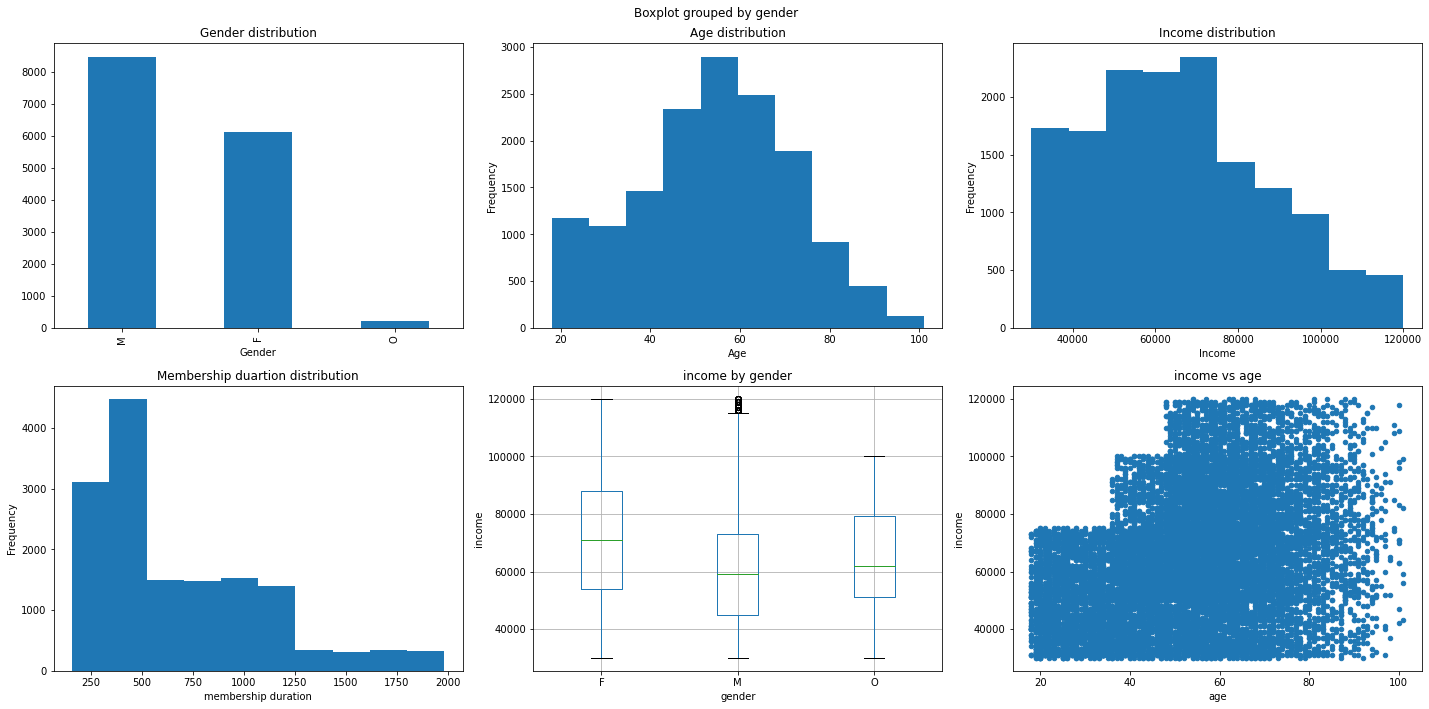

In [15]:
# Population characteristics


fig, ax = plt.subplots(2,3, figsize=(20,10))

profile.gender.value_counts().plot(kind='bar', ax=ax[0,0])
ax[0,0].set_title("Gender distribution")
ax[0,0].set_xlabel("Gender")

profile.age.plot(kind='hist', ax=ax[0,1])
ax[0,1].set_title("Age distribution")
ax[0,1].set_xlabel('Age')

profile.income.plot(kind='hist', ax=ax[0,2])
ax[0,2].set_title("Income distribution")
ax[0,2].set_xlabel('Income')

profile.membership_period.plot(kind='hist', ax=ax[1,0])
ax[1,0].set_title('Membership duartion distribution')
ax[1,0].set_xlabel('membership duration')

profile.boxplot(column='income', by='gender', ax=ax[1,1])
ax[1,1].set_title("income by gender")
ax[1,1].set_ylabel("income")

profile.plot(x='age', y='income', kind='scatter', ax=ax[1,2])
ax[1,2].set_title("income vs age")

plt.tight_layout()
plt.show()

**Observations of Profile dataframe**

- In the total population the number of males are more than number of females with a very low number of other gender.

- The age of users are normally distributed with a peak around 55-60 years of age.

- The income of users are skewed to the left.

- The income for females are higher compared to males and other gender.

- The income for older population is higher compared to younger population

#### Offer final dataset for analysis

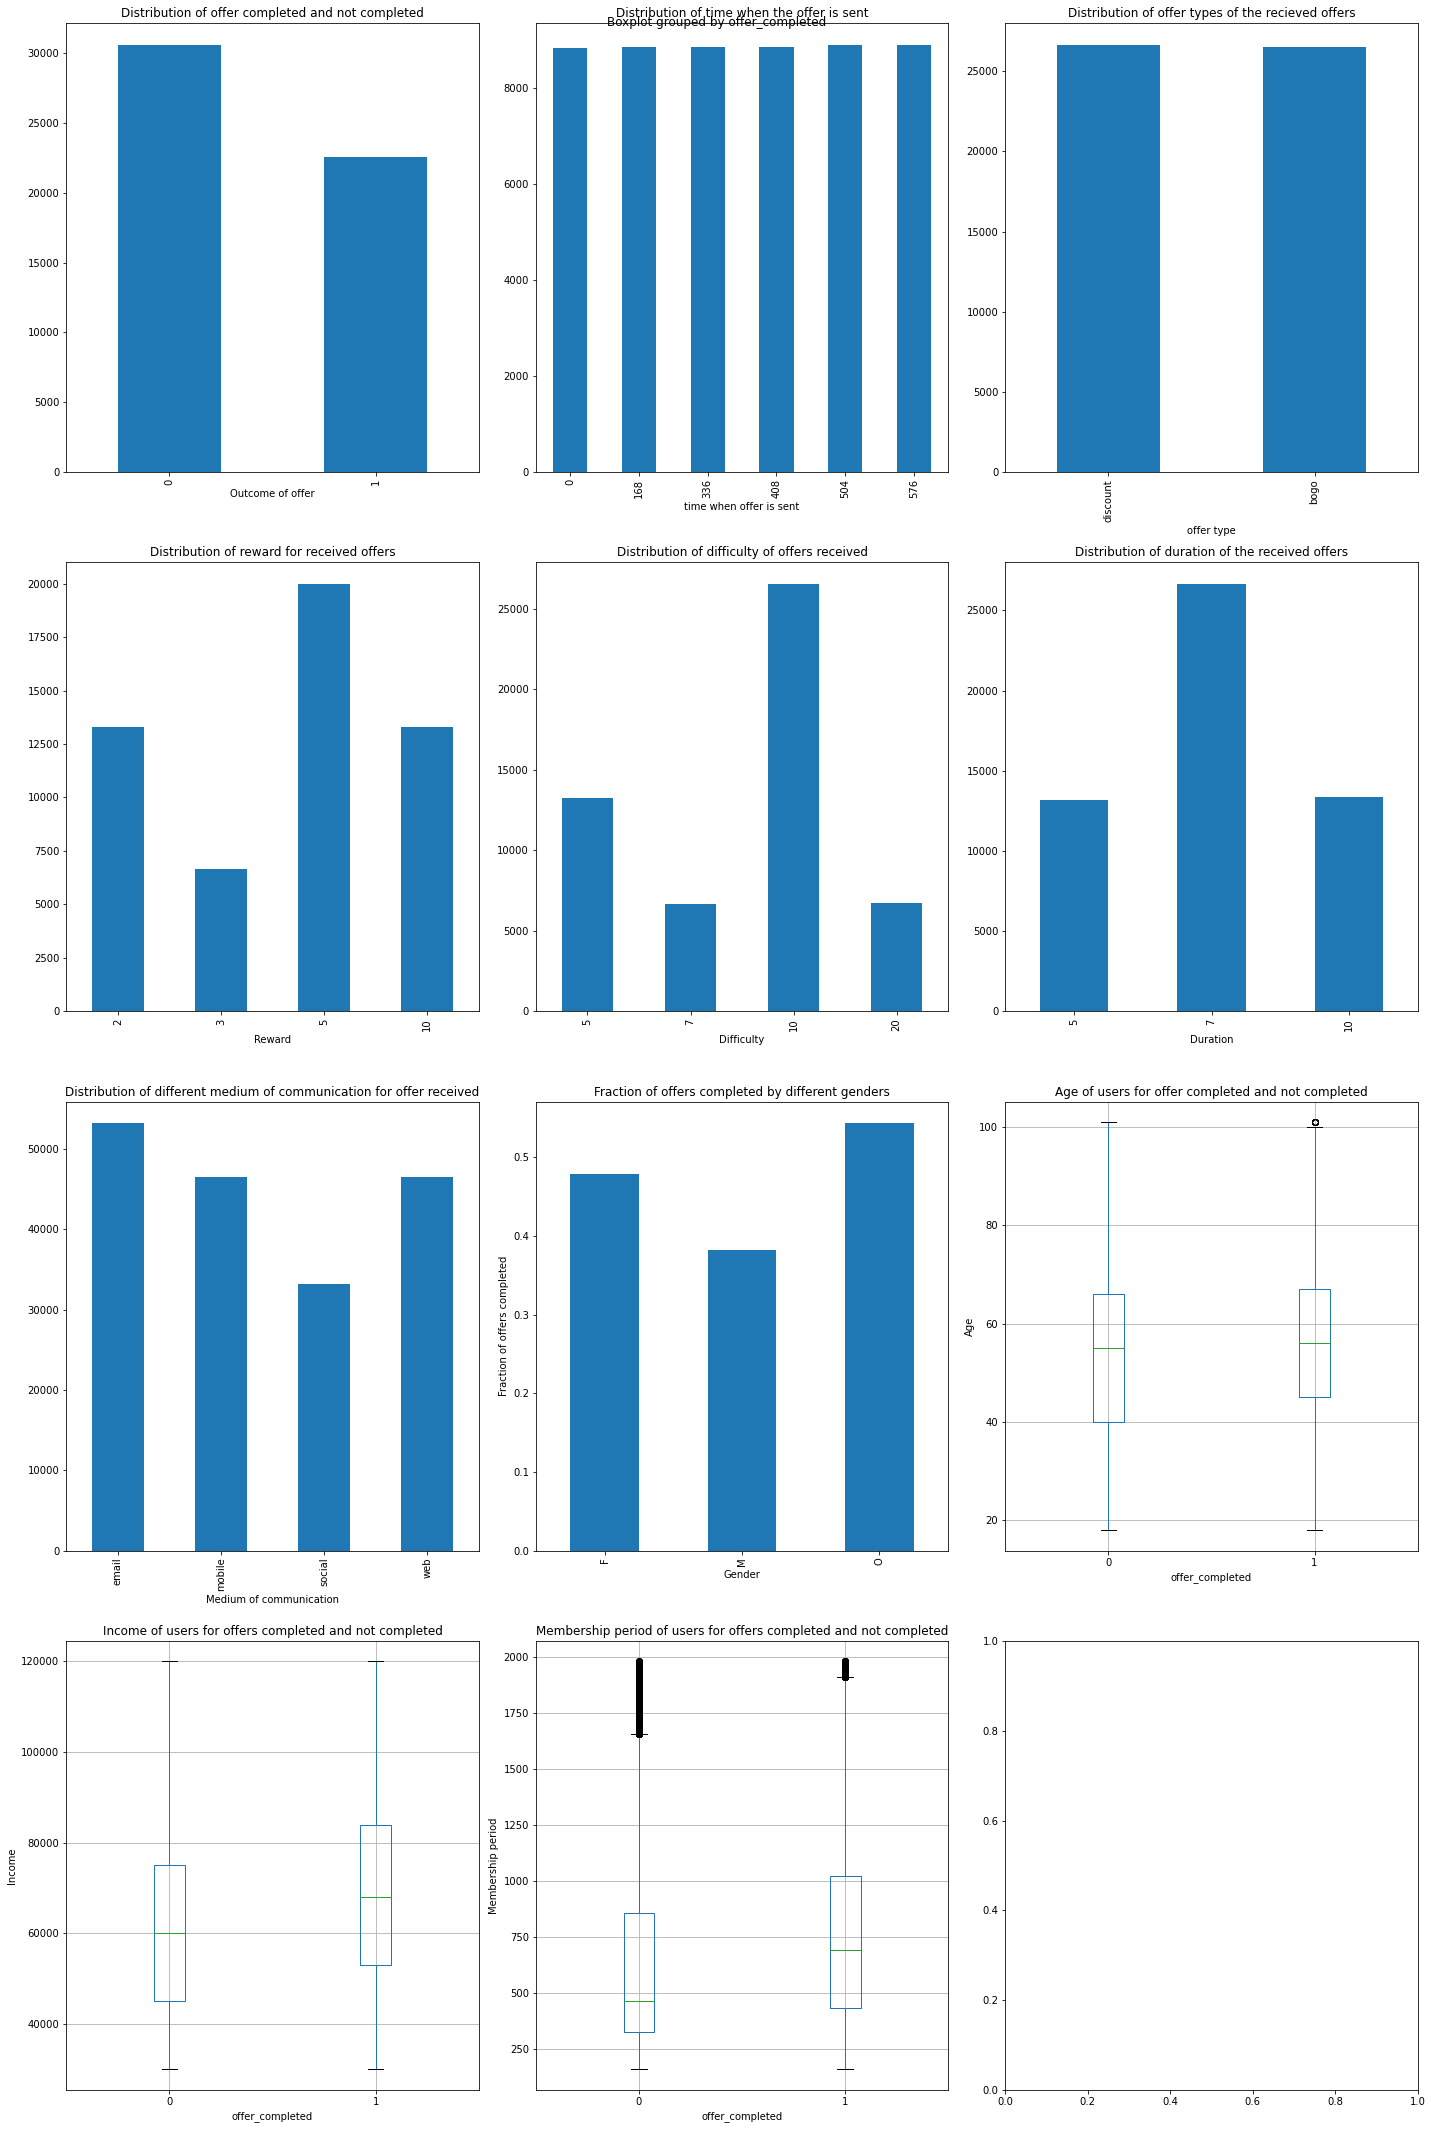

In [16]:
fig, ax = plt.subplots(4,3, figsize=(20,30))

offer_final_df.offer_completed.value_counts().plot(kind='bar', ax=ax[0,0])
ax[0,0].set_title("Distribution of offer completed and not completed")
ax[0,0].set_xlabel("Outcome of offer")

offer_final_df.time_offer_start.value_counts().sort_index().plot(kind='bar', ax=ax[0,1])
ax[0,1].set_title("Distribution of time when the offer is sent")
ax[0,1].set_xlabel("time when offer is sent")

offer_final_df.offer_type.value_counts().plot(kind='bar', ax=ax[0,2])
ax[0,2].set_title("Distribution of offer types of the recieved offers")
ax[0,2].set_xlabel("offer type")

offer_final_df.reward.value_counts().sort_index().plot(kind='bar', ax=ax[1,0])
ax[1,0].set_title("Distribution of reward for received offers")
ax[1,0].set_xlabel("Reward")

offer_final_df.difficulty.value_counts().sort_index().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title("Distribution of difficulty of offers received")
ax[1,1].set_xlabel("Difficulty")

offer_final_df.duration.value_counts().sort_index().plot(kind='bar', ax=ax[1,2])
ax[1,2].set_title("Distribution of duration of the received offers")
ax[1,2].set_xlabel("Duration")

offer_final_df[["email", "mobile", "social", "web"]].sum().plot(kind='bar', ax=ax[2,0])
ax[2,0].set_title("Distribution of different medium of communication for offer received")
ax[2,0].set_xlabel("Medium of communication")

offer_final_df.groupby(by='gender')["offer_completed"].mean().plot(kind='bar', ax=ax[2,1])
ax[2,1].set_title("Fraction of offers completed by different genders")
ax[2,1].set_xlabel("Gender")
ax[2,1].set_ylabel("Fraction of offers completed")

offer_final_df.boxplot(column="age", by="offer_completed", ax=ax[2,2])
ax[2,2].set_title("Age of users for offer completed and not completed")
ax[2,2].set_ylabel("Age")

offer_final_df.boxplot(column="income", by="offer_completed", ax=ax[3,0])
ax[3,0].set_title("Income of users for offers completed and not completed")
ax[3,0].set_ylabel("Income")

offer_final_df.boxplot(column="membership_period", by="offer_completed", ax=ax[3,1])
ax[3,1].set_title("Membership period of users for offers completed and not completed")
ax[3,1].set_ylabel("Membership period")

plt.tight_layout()
plt.show()

**Observations of offer final dataset**

- The outcome(offer completed / not completed) is not imbalaced (40% - 60% split).

- The median income of the users that completed offer vs not completed seems to have a significant difference.

- The median membership_period seems to have a significant difference for the users that completed the offers vs not completed.


## 5. Model building

In [17]:
# one hot encode the categorical columns
offer_final_df = offer_final_df.join(pd.get_dummies(offer_final_df[["offer_type", "gender"]]))

# remove the unwanted features
offer_final_df.drop(columns=["time_offer_start", "time_offer_end", "gender", "offer_type"], inplace=True)

# split the data into train and test data
X = offer_final_df.loc[:, offer_final_df.columns != "offer_completed"]
y = offer_final_df.loc[:, "offer_completed"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)

In [18]:
def build_model():
    '''
    Instanciate the model
    
    Output:
        cv -> cross validation model
    '''
    pipeline = Pipeline([
        ('scale', MinMaxScaler()),
        ('clf', GradientBoostingClassifier())
    ])
    
    # hyperparameters for the Gradinet Boosting Model
    parameters = {
        "clf__n_estimators": [50, 100, 200],
        "clf__learning_rate": [0.1, 0.01],
        "clf__max_depth": [5, 10],
        "clf__min_samples_split": [2, 10],
        "clf__min_samples_leaf": [2, 10, 20]
    }
    
    # run cross validation on the model
    cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)
    
    return cv



In [20]:
# build the cross validation model

model = build_model()
model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('clf', GradientBoostingClassifier())]),
             param_grid={'clf__learning_rate': [0.1, 0.01],
                         'clf__max_depth': [5, 10],
                         'clf__min_samples_leaf': [2, 10, 20],
                         'clf__min_samples_split': [2, 10],
                         'clf__n_estimators': [50, 100, 200]})

In [56]:
# pick the best cross validation model

best_model = model.best_estimator_
y_pred = best_model.predict(X_test)

# calculate the model evaluation metrics
clf_result_test = classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)['accuracy']
clf_result_train = classification_report(y_true = y_train, y_pred = best_model.predict(X_train), output_dict=True)['accuracy']

# print the metrics

print(f"The accuracy score for training dataset is {clf_result_train} and for test dataset is {clf_result_test}")

The accuracy score for training dataset is 0.7341165413533834 and for test dataset is 0.712808946527582


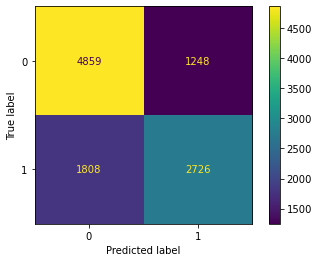

In [57]:
# Display the confusion matrix

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

In [58]:
# Display the parameters of the best model

model.best_params_

{'clf__learning_rate': 0.1,
 'clf__max_depth': 5,
 'clf__min_samples_leaf': 10,
 'clf__min_samples_split': 2,
 'clf__n_estimators': 200}

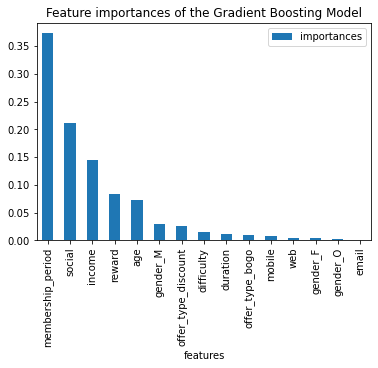

In [59]:
# plot the feature importances

feature_imp_df = pd.DataFrame({"features": X_train.columns,
                               "importances": best_model.named_steps["clf"].feature_importances_})

feature_imp_df.sort_values(by="importances", ascending=False).\
                plot(x="features", y="importances" ,kind='bar')
plt.title("Feature importances of the Gradient Boosting Model");

**Discussions**

- Gradient Boosting Classifier is used a model and accuracy is used the metric of evaluation

- Even after changing the hyperparameters the accuracy seems to be in the range of 70 %.


## 6. Conclusion

- The project had the objective of building a model to be able to identify if an offer sent to a particular customer will be completed or not. The model built in this case was a gradient boosting classifier.

- This problem had a big challenge of figuring out offers that were viewed and completed as there was no unique id of the offers. To tackle this issue, offer date was used to make a relationship. It worked fairly well but there are other approaches as well.

- The model can be improved by introducing new features like number of unsuccessful offers before conversion, making the income and age as groups rather than individual values, etc. Also there can other approaches like consider one entry for each conversion (one entry per customer and offer pair).

- Other ML classification models like XGBoost can also be used for better accuracy.